generating noise
starting compression


<IPython.core.display.Javascript object>


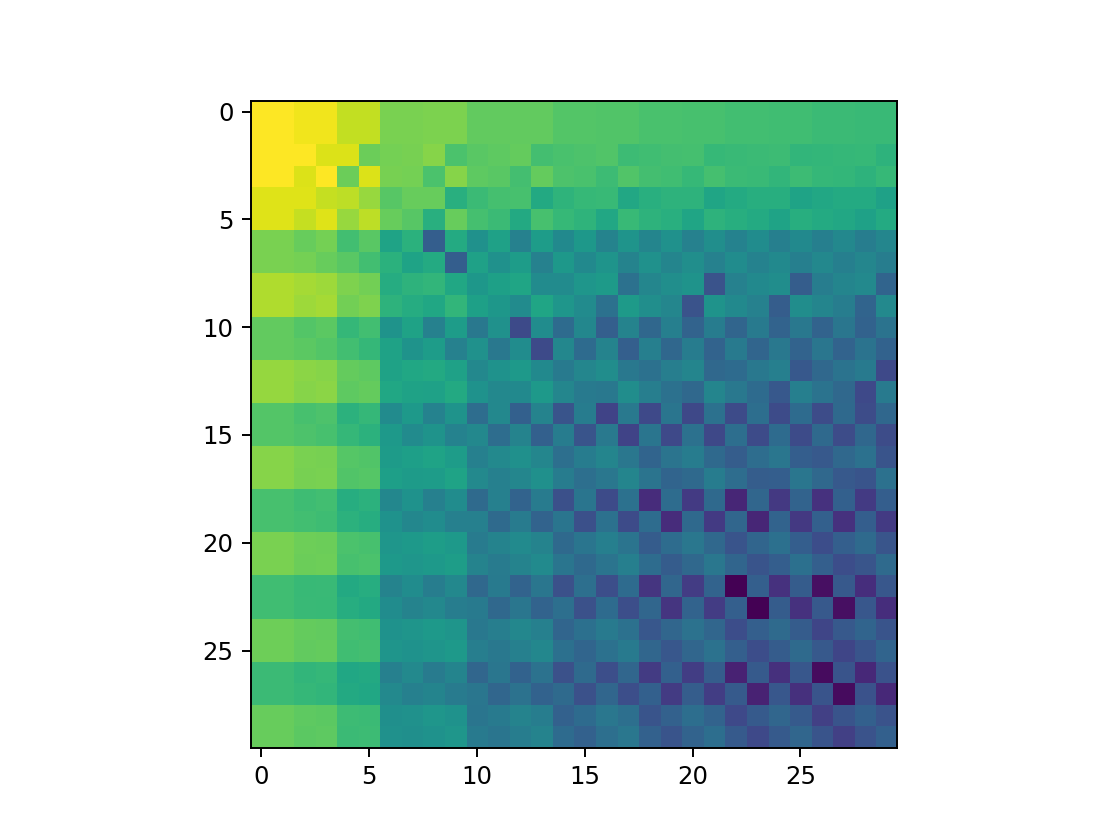

compression time:  0.9179940223693848
starting decompression
number of output paramaters:  900  error:  19.420122685358475 decompression time:  1.3380661010742188


<IPython.core.display.Javascript object>


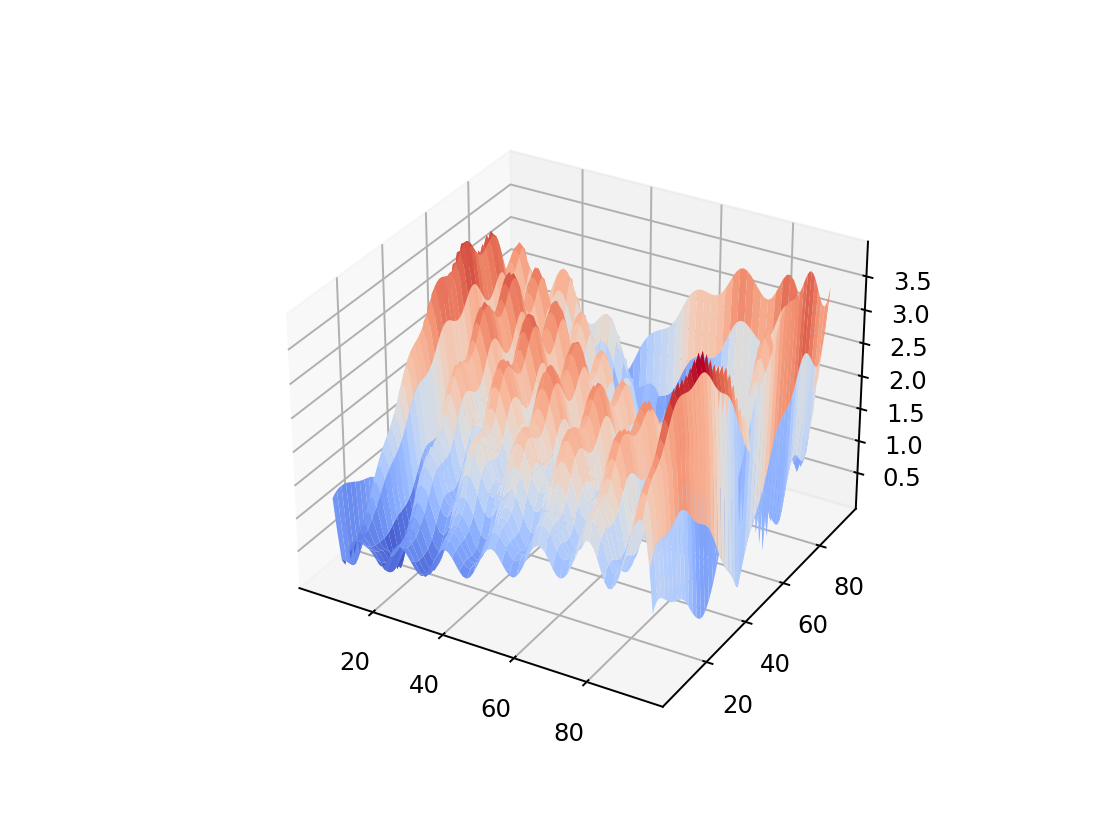

<IPython.core.display.Javascript object>


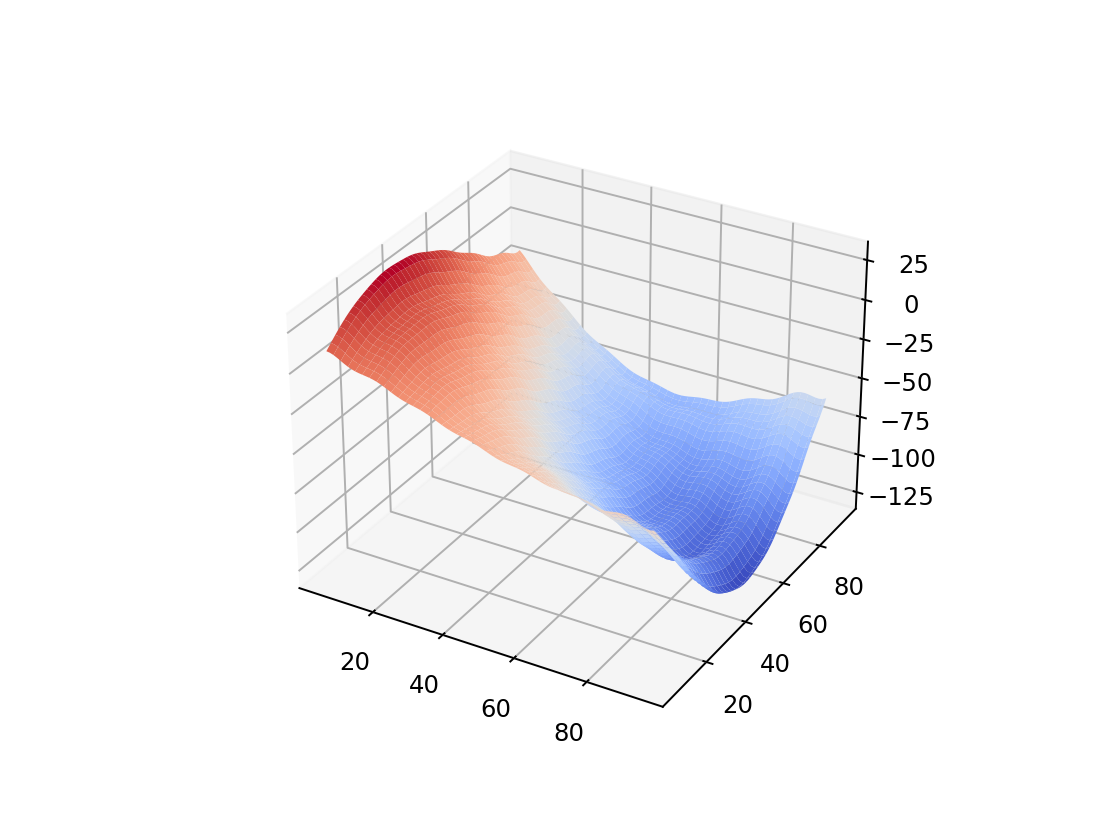

<IPython.core.display.Javascript object>


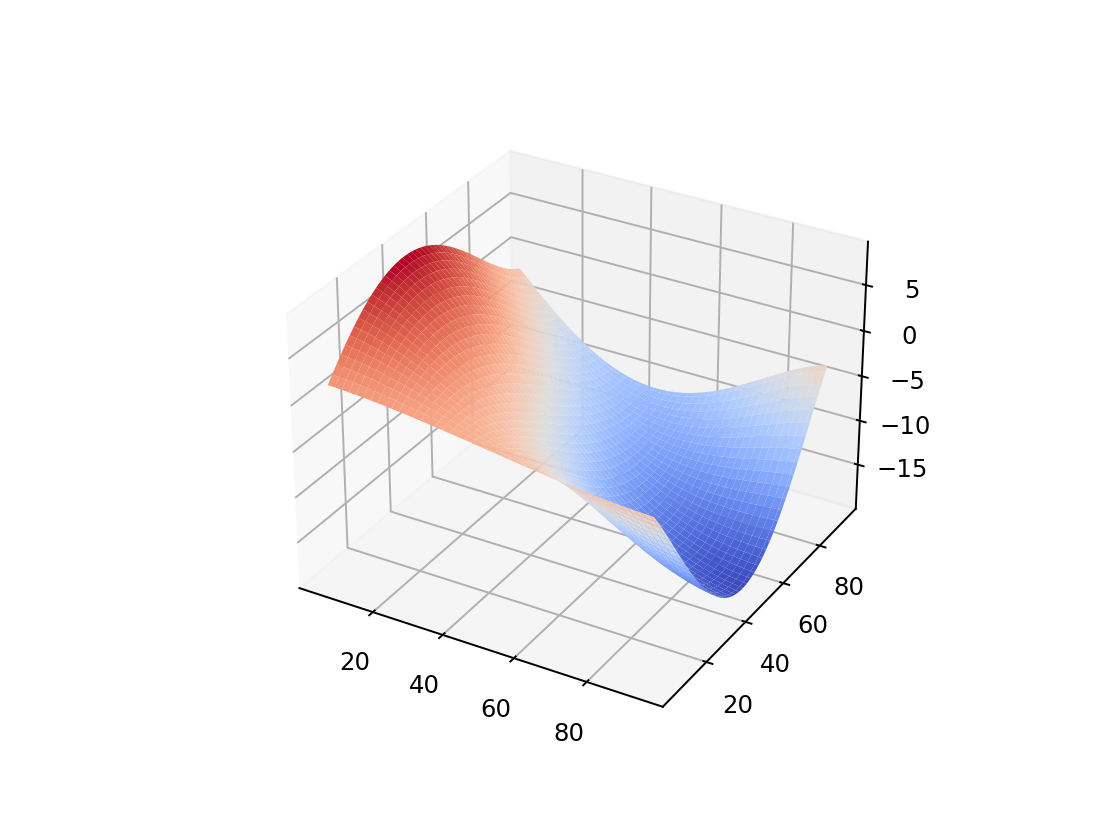

In [11]:
import numpy as np
import time
import PerlinNoise as pn
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib notebook

# visualisation
def graph(X,Ys):
    if len(X[0].shape) == 1:
        fig = plt.figure()
        for f in Ys:
            plt.plot(X,f)
    else:
        for f in Ys:
            fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
            topo = ax.plot_surface(X[0],X[1],f, cmap = cm.coolwarm)
    plt.show()

# helper functions
def make_domain(a,b,dx=1, inclusive = False):
    if len(a) == 1:
        return np.arange(a,b+inclusive,dx)
    elif len(a) == 2:
        return np.mgrid[a[0]:b[0]+inclusive:dx,a[1]:b[1]+inclusive:dx]
    
# sampling from a function
def calculate_1D(f,args,a,b,dx = 0.01):
    X = np.arange(a,b,dx*1j)
    Ys = np.zeros((len(f),len(X)), dtype = complex)
    for i in range(len(f)):
        for x in range(len(X)):
            Ys[i,x] = f[i](X[x],args[i])
    return X,Ys

def calculate(fs,args,a,b,dx = 1):
    X = make_domain(a,b,dx)
    Ys = np.zeros([len(fs)]+list(X[0].shape), dtype = complex)
    for i in range(len(fs)):
        Ys[i] = fs[i](X,args[i])
    return X,Ys

# error functions
def error(y_real, y_result):
    return ((np.absolute(y_real)-np.absolute(y_result))**2).sum()

# normalised to scale with varying domain sizes
def normalised_error(y_real, y_result):
    return error(y_real, y_result)/np.array(y_real.shape).prod()

def max_error(y_real, y_result):
    return np.max(np.absolute(y_real)-np.absolute(y_result))

# value calculation (~decompression)
def fourier_series_1D(x,c):
    """
    fourier_series uses calculated coefficients to determine the corresponding values across the supplied domain.
    The domain to be evaluated across should lie within the functional domain.
    
    :param X<Array<Real>                  : The domain to be evaluated across by the fourier series
    :param c<(Array<Complex>,Array<Real>> : A tuple of an NxN coefficient matrix and the defined domain
    :return F<Array<Real>>                : The output values of the fourier series evaluated at X
    """
    F = c[0]
    N = int((c.size-1)/2)
    _range = b-a
    for n in range(1,N+1):
        F+=c[2*n]*np.exp(-n*x*(1j)*2*np.pi/_range,dtype = complex)
        F+=c[2*n-1]*np.exp(n*x*(1j)*2*np.pi/_range,dtype = complex)
    return F

def fourier_series(X,c):
    """
    fourier_series uses calculated coefficients to evaluate the function values across the supplied domain.
    The domain to be evaluated across should lie within the functional domain.
    
    :param X<Array<Real>                  : The domain to be evaluated across by the fourier series
    :param c<(Array<Complex>,Array<Real>> : A tuple of an NxN coefficient matrix and the defined domain
    :return F<Array<Real>>                : The output values of the fourier series evaluated at X
    """
    _range = c[1][1]-c[1][0]
    c = c[0]
    F = np.zeros(X[0].shape, dtype = complex)
    N = ((np.array(c.shape))/2).astype(int)
    for n1 in range(N[0]):
        for n2 in range(N[1]):
            temp = (1j)*np.pi*(X*(np.array((n1,n2))/_range)[:,np.newaxis,np.newaxis])
            F += c[2*n1+1, 2*n2+1]*np.exp(-temp.sum(axis = 0),dtype = complex)
            F += c[2*n1+1, 2*n2]*np.exp(temp[1]-temp[0],dtype = complex)
            F += c[2*n1, 2*n2+1]*np.exp(temp[0]-temp[1],dtype = complex)
            F += c[2*n1, 2*n2]*np.exp(temp.sum(axis = 0),dtype = complex)
    return F

# partial derivitives
def fourier_series_dy_dx(X,c):
    """
    Similar to fourier_series(), fourier_series_dy_dx() uses the coefficients to calculate the partial
    derivitives of the terrain (to calculate the gradient)
    
    :param X<Array<Real>                  : The domain to be evaluated across by the fourier series
    :param c<(Array<Complex>,Array<Real>> : A tuple of an NxN coefficient matrix and the defined domain
    :return F<Array<Real>>                : The output values of the fourier series evaluated at X
    """
    _range = c[1][1]-c[1][0]
    c = c[0]
    F = np.zeros([2]+list(X[0].shape), dtype = complex)
    N = ((np.array(c.shape))/2).astype(int)
    for n1 in range(N[0]):
        for n2 in range(N[1]):
            if n1 == 0 and n2 == 0:
                continue
            const = (1j)*np.pi*(np.array((n1,n2))/_range)[:,np.newaxis,np.newaxis]
            temp = X*const
            F += c[2*n1+1, 2*n2+1]*np.exp(-temp.sum(axis = 0),dtype = complex)*-const
            F += c[2*n1+1, 2*n2]*np.exp(temp[1]-temp[0],dtype = complex)*np.array((const[1],-const[0]))
            F += c[2*n1, 2*n2+1]*np.exp(temp[0]-temp[1],dtype = complex)*np.array((const[0],-const[1]))
            F += c[2*n1, 2*n2]*np.exp(temp.sum(axis = 0),dtype = complex)*const
    return F

def fourier_series_grad_mag(X,c):
    # return fourier_series_dy_dx(X,c)[0]
    # return fourier_series_dy_dx(X,c)[1]
    return np.sqrt((fourier_series_dy_dx(X,c).real**2).sum(axis = 0))

# coefficient calculation (~compression)
def fourier_coef_cont(f,args,N,a,b,precision = 0,dx = 0.01):
    """
    Fourier_coef_cont approximates the coefficients of the fouier series of a continuous function
    Using fourier series on functions is generally unapplicable, but it provides the ability to test
    :param f<function>       : The function to be approximated using fourier series
    :param args<list>        : The arguments of the input function (e.g phase offset, amplitude, frequency, ect)
    :param N<Natural>        : The number of coefficients
    :param a,b<Real>         : The domain of interest [a,b]
    :param precision<Decimal>: The acceptable approximate error percentage of the function for preemptive termination (for large N)
    :param dx<PositiveReal>  : Step size for trapezoidal numerical integration
    :return c<list<Complex>> : List of the N first coefficients 
    """
    c = np.zeros(2*N+1, dtype = complex)
    X = np.array([a+x*dx for x in range(int((b-a)/dx+1))])
    Y = np.array([f(x, args) for x in X])
    c[0] = 1/(b-a)*np.trapz(Y,dx =dx)
    precision*=np.max(Y)/N if N >=1 and precision >=0 else -1
    for n in range(1,N+1):
        c[2*n] = 1/(b-a)*np.trapz([Y[x]*np.exp(n*X[x]*(1j)*2*np.pi/(b-a),dtype = complex) for x in range(X.size)],dx=dx)
        c[2*n-1] = 1/(b-a)*np.trapz([Y[x]*np.exp(-n*X[x]*(1j)*2*np.pi/(b-a),dtype = complex) for x in range(X.size)],dx=dx)
        if np.absolute(c[2*n]) <= precision or np.absolute(c[2*n-1]) <= precision:
            break
    return c[:2*n+1]

def fourier_coef_1D(X,Y,N, precision = 0.0, dx = 1):
    """
    Fourier_coef_1D approximates the coefficients of the fouier series of a discrete function
    This one uses midpoint integral approximation on a continuous function
    :param X<list<Real>      : The domain of a discrete function
    :param Y<list<Real>>     : The range of a discrete function, mapped from X
    :param N<Natural>        : The number of coefficients
    :param precision<Decimal>: The acceptable approximate error percentage used for early termination
    :return c<list<Complex>> : List of the N first coefficients 
    """
    N = int(N)
    c = np.zeros(2*N+1, dtype = complex)
    _range = np.max(X)-np.min(X)
    c[0] = Y.sum()/X.size
    precision*=np.max(Y)/N if N >=1 and precision >=0 else -1
    for n in range(1,N+1):
        c[2*n] = (Y*np.exp(n*X*(1j)*2*np.pi/_range)).sum()/(X.size*dx)
        c[2*n-1] = (Y*np.exp(-n*X*(1j)*2*np.pi/_range)).sum()/(X.size*dx)
        if np.absolute(c[2*n]) <= precision or np.absolute(c[2*n-1]) <= precision:
            c[:2*n+1]
    return c

def fourier_coef(X,Y,compression_ratio, dx = 1):
    """
    Fourier_coef approximates the coefficients of the fouier series of a discrete function.
    It is O(|N|*|X|) complexity where N is the number of coefficients dictated by the 
    compression ratio and X is the indices to the input data set Y.
    For large datasets, dx samples homogenously to drastically increase speed by O(dx^dim(X))
    by reducing the effective resolution of the data, but for smooth outputs the output size may be 
    smaller to prevent "overfitting". 
    
    :param X<Array<Real>             : The domain of a discrete function, the last index is the coordinates
    :param Y<Array<Real>>            : The range of the discrete function, mapped from X
    :param compression_ratio<Decimal>: The ratio of output data size over input data size
    :param dx<Integer >=1>           : The sampling rate (from the dataset, |X|/dx^2 datapoints are sampled)
    :return c<(Array<Complex>,Array<Real>> : A tuple of an NxN coefficient matrix and the defined domain
    """
    compression_ratio = min(compression_ratio, 4/dx**2)
    N = np.floor(np.sqrt(compression_ratio*np.array(X[0].shape)**2)/2).astype(int)
    c = np.zeros(2*N, dtype = complex)
    domain = np.array([[np.min(x_axis),np.max(x_axis)+1] for x_axis in X]).T
    _range = domain[1]-domain[0]
    X = X[:,::dx,::dx]
    Y = Y[::dx,::dx]
    d = np.array(Y.shape).prod()
    for n1 in range(N[0]):
        for n2 in range(N[1]):
            n = np.array((n1,n2))
            temp = (1j)*np.pi*(X*(n/_range)[:,np.newaxis,np.newaxis])
            c[2*n1+1, 2*n2+1] = (Y*np.exp(temp.sum(axis = 0))).sum()/d
            c[2*n1+1, 2*n2] = (Y*np.exp(temp[0]-temp[1])).sum()/d
            c[2*n1, 2*n2+1] = (Y*np.exp(temp[1]-temp[0])).sum()/d
            c[2*n1, 2*n2] = (Y*np.exp(-temp.sum(axis = 0))).sum()/d
    return (c,domain)

# test functions
def complex_cosine(x, args):
    return (np.exp(args[0]*(x+args[1])*1j,dtype = complex)+np.exp(-args[0]*(x+args[1])*1j,dtype = complex))/2

def test(x,args):
    return 5 if x < 5 else 10
    return 1/x if x!= 0 else 0         #inverse, but without the singularity for graphing simplicity
    return np.sin(x)

# simply access the index for a given x value
def discrete(x, Y):
    return Y[x] if type(x) == int else Y[x[0],x[1]]

def discrete_interp(x,args):
    pass

# testing
def test_continuous_1D():
    return None
    a = 0.1#-np.pi
    b = 10#np.pi
    N = 3
    prec = -0.01
    time1 = time.time()
    x,y = calculate([test],[0],a,b)
    c3 = fourier_coef(x,y,N, prec)
    print(c3.size)
    x,ys = calculate([fourier_series, test],[c3, y],a,b)
    print(time.time()-time1, normalised_error(y,ys, b-a))
    graph(x,ys)
    #################
    time1 = time.time()
    c3 = fourier_coef_cont(test,0,N,a,b, prec)
    print(c3.size)
    x,ys = calculate([fourier_series, test],[c3,0],a,b)
    print(time.time()-time1, normalised_error(y,ys, b-a))
    graph(x,ys)
    #plt.plot([-np.pi,-np.pi],[np.min(np.array(ys)),np.max(np.array(ys))]) #test for symmetry

def test_random_discrete_2D():
    a = (0,0)
    b = (100,100)
    compression_ratio = 0.1
    dxin = 1
    dxout = 1
    print("generating noise")
    noise = pn.PerlinNoise(np.array(b)-np.array(a),25087)
    noise.generate_fractal(np.array([b[0]*1]),[10])#generate_conc(200)
    time1 = time.time()
    print("starting compression")
    c3 = fourier_coef(make_domain(a,b),noise.noise,compression_ratio, dxin)
    plt.imshow(np.log(np.absolute(c3[0])))
    plt.show()
    print("compression time: ",time.time()-time1)
    print("starting decompression")
    time1=time.time()
    x,ys = calculate([fourier_series_grad_mag, fourier_series, discrete],[c3, c3,noise.noise],a,b, dxout)
    print("number of output paramaters: ",c3[0].size," error: ",max_error(noise.noise[::dxout,::dxout],ys[0]), "decompression time: ",time.time()-time1)
    graph(x[:,5:-5,5:-5],ys[:,5:-5,5:-5])

test_random_discrete_2D()

# Capability classes:
# slope

# The Fourier series code uses this source: https://math24.net/complex-form-fourier-series.html#example1
# and extension to higher dimensions was inspired by the video https://www.youtube.com/watch?v=Q2aEzeMDHMA